# Màquines de Factorització


En aquest notebook es mostra com aplicar una màquina de factoritzacio a un problema de **classificació**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import warnings
warnings.filterwarnings('ignore')

Els algorismes coneguts com a **Màquina de Factorització** són una combinació de regressió lineal i factorització matricial orientats a la recomanació d'ítems. 

### Introducció

Normalment, quan pensem en regressió lineal, pensem en la fórmula següent:

\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i}
\end{align}

on $w_0$ és el biaix i  $w_i$ són els pesos corresponent a cada característica $x_i$ de les dades, suposant que tenim $n$ característiques en total.

L'avantatge d'aquesta fórmula és que és simple i es pot calcular en temps lineal, $O(n)$. L'inconvenient, però, és que no gestiona les interaccions entre les característiques.

Per capturar les interaccions, podríem introduir un pes per a cada combinació de dues característiques. El model resultant es mostra a continuació:

\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i} +  \sum_{i=1}^n \sum_{j=i+1}^n w_{ij} x_{i} x_{j}
\end{align}

En comparació amb el nostre model anterior, aquesta formulació té l'avantatge que pot capturar interaccions de característiques almenys per a dues característiques alhora. El problema és que ara hem acabat amb una complexitat $O(n^2)$, la qual cosa significa que per entrenar el model necessitem molt més temps i memòria. 

Un altre problema és que quan tenim variables categòriques amb una cardinalitat elevada, s'han de codificar amb una estratègia de *one-hot encoding*, i llavors acabaríem amb moltes columnes amb molts zeros, cosa que dificulta la captura de les seves interaccions (no hi ha prou dades).

Per resoldre aquest problema de complexitat, les Màquines de Factorització s'inspiren en la factorització de matrius i modelen la interacció de les característiques utilitzant factors latents. 

Cada característica $x_i$ té un factor latent corresponent $\textbf{v}_i$, i les interaccions de dues característiques es modelen com $\langle \textbf{v}_i , \textbf{v}_{j} \rangle$, on $\langle \cdot,\cdot \rangle$ fa referència al producte escalar dels vectors de característiques. 

Si suposem que els vectors són de mida $k$ (aquest és un hiperparàmetre que podem ajustar). Llavors:

\begin{align}
\langle \textbf{v}_i , \textbf{v}_{j} \rangle = \sum_{f=1}^k v_{i,f} v_{j,f}
\end{align}

Com a resultat de tot això tenim:

\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i} + \sum_{i=1}^{n} \sum_{j=i+1}^n \langle \textbf{v}_i , \textbf{v}_{j} \rangle x_i x_{j}
\end{align}

Això és una millora respecte al nostre model anterior ja que el nombre de paràmetres es redueix de $n^2$ a $n \times k$ , ja que $k < n$, que també ajuda a mitigar els problemes de sobreajust. 

L'ús de la manera ingènua de formular la màquina de factorització dóna com a resultat una complexitat de $O(k n^2)$, perquè s'han de calcular totes les interaccions per parelles, però podem reformular-les perquè s'executi en $O(kn)$ . 


\begin{align}
\sum_{i=1}^n \sum_{j=i+1}^n \langle \textbf{v}_i, \textbf{v}_{j} \rangle x_{i} x_{j}
&= \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \langle \textbf{v}_i, \textbf{v}_{j} \rangle x_{i} x_{j} - \frac{1}{2} \sum_{i=1}^n \langle \textbf{v}_i , \textbf{v}_{i} \rangle x_{i} x_{i}  \\
&= \frac{1}{2}\left(\sum_{i=1}^n \sum_{j=1}^n \sum_{f=1}^k v_{i,f} v_{j,f} x_{i} x_{j} \right)\frac{1}{2}\left( \sum_{i=1}^n \sum_{f=1}^k v_{i,f} v_{i,f} x_{i} x_{i} \right) \\
&= \frac{1}{2}\left(\sum_{i=1}^n \sum_{j=1}^n \sum_{f=1}^k v_{i,f} v_{j,f} x_{i} x_{j}  -  \sum_{i=1}^n \sum_{f=1}^k v_{i,f} v_{i,f} x_{i} x_{i} \right) \\
&= \frac{1}{2} \sum_{f=1}^{k} \left( \left(\sum_{i=1}^n v_{i,f}x_{i} \right) \left( \sum_{j=1}^n v_{j,f}x_{j} \right) - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right) \\
&= \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i}^{n} v_{i,f}x_{i} \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right)
\end{align}

Tingueu en compte que sumar diferents parells és el mateix que sumar tots els parells menys les autointeraccions (dividit per dos). Aquesta és la raó per la qual s'introdueix el valor 1/2 des de l'inici de la derivació.

Aquesta equació reformulada té una complexitat lineal tant en $k$ com en $n$, és a dir, el seu càlcul és en $O(kn)$, substituint aquesta nova equació a la fórmula de la màquina de factorització existent, acabem amb:

\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i} + \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i}^{n} v_{i,f}x_{i} \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right)
\end{align}

La màquina de factorització es pot aplicar a diferents tasques de predicció (a més a més de la recomanació que hem vist a classe):

- **Regressió:**, en aquest cas $\hat{y}(\textbf{x})$ es pot utilitzar directament minimitzant l'error quadrat mitjà entre la predicció del model i el valor objectiu, p. $\frac{1}{N}\sum^{N}\big(y - \hat{y}(\textbf{x})\big)^2$
- **Classificació:**, si l'utilitzem en una configuració de classificació binària, podríem minimitzar la pèrdua, $\ln \big(e^{-y \cdot \hat{y}(\textbf{ x})} + 1 \big)$, on $\sigma$ és la funció sigmoide/logística.

Per entrenar la màquina de factorització, podem utilitzar tècniques d'optimització basades en **descens del gradient**, i llavors els paràmetres a aprendre són $(w_0, \mathbf{w},$ i $\mathbf{V}$).

\begin{align}
\frac{\partial}{\partial\theta}\hat{y}(\textbf{x}) =
\begin{cases}
1,  & \text{if $\theta$ is $w_0$} \\
x_i, & \text{if $\theta$ is $w_i$} \\
x_i\sum_{j=1}^{n} v_{j,f}x_j - v_{i,f}x_{i}^2 & \text{if $\theta$ is $v_{i,f}$}
\end{cases}
\end{align}

- Observeu que $\sum_{j=1}^n v_{j, f} x_j$ no depèn de $i$, per tant es pot calcular independentment.
- L'última fórmula anterior també es pot escriure com $x_i(\sum_{j=1}^{n} v_{j,f}x_j - v_{i,f}x_{i})$.

Com que la secció següent conté la implementació de l'algorisme des de zero, aquí també es proporciona el gradient de la funció de pèrdua. El valor previst $\hat{y}(\textbf{x})$ es substitueix per $x$ per fer la notació més neta.


\begin{align}
\frac{d}{dx}\left[ \ln \big(e^{-yx} + 1 \big) \right] 
&= \frac{1}{e^{-yx} + 1} \cdot  \frac{d}{dx}\left[e^{-yx} + 1 \right] \\
&= \frac{\frac{d}{dx}\left[e^{-yx} \right] + \frac{d}{dx}\left[1 \right]}{e^{-yx} + 1} \\
&= \frac{e^{-yx} \cdot \frac{d}{dx}\left[-yx \right] + 0}{e^{-yx} + 1} \\
&= \frac{e^{-yx} \cdot -y}{e^{-yx} + 1} \\
&= -\frac{ye^{-yx}}{e^{-yx} + 1} \\
&= -\frac{y}{e^{yx} + 1}
\end{align}

### Implementació d'un classificador fent servir màquines de factorització.

El problema de classificació que considerarem és el de classificar e-mails com a `spam` o `no-spam`. 

Farem servir un dataset de *spam* en anglès: `sms.tsv` i un model $\mbox{tf-idf}$ per codificar el text dels missatges i convertir-lo en un vector de valors reals.

In [3]:
label_col = 'label_num'
sms = pd.read_table('sms.tsv', header = None, names = ['label', 'message'])
sms[label_col] = sms['label'].map({'ham': -1, 'spam': 1}) # Change the 'ham' to -1 is to test exercise 4
X = sms['message']
y = sms[label_col].values
print('Exemple negatiu: ',y[10],':',X[10])
print('Exemple positiu: ',y[2],':',X[2])

Exemple negatiu:  -1 : I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
Exemple positiu:  1 : Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


In [4]:
# creació dels conjunts d'aprenentatge
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 1)
print("Nombre d'exemples al conjunt de training: ",X_train.size)

# codificació de les dades
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.5)
X_train_dtm = tfidf.fit_transform(X_train)
X_test_dtm = tfidf.transform(X_test)

print("Nombre total de paraules                : ",X_train_dtm.size)
print("Nombre de paraules diferents            : ",X_train_dtm.shape[1])

Nombre d'exemples al conjunt de training:  4179
Nombre total de paraules                :  51261
Nombre de paraules diferents            :  3508


In [13]:
import math  # Important execrice 2.5

In [26]:
import numpy as np
from tqdm import trange
from sklearn.base import BaseEstimator, ClassifierMixin

class FactorizationMachineClassifier(BaseEstimator, ClassifierMixin):
    """
    Màquina de factorització amb descens estocàstic del gradient.
    Funciona per classificació binaria només.

    Parametres
    ----------
    n_iter : int, default 10
        Nombre d'iteracions per entrenar l'algorisme.

    n_factors : int, default 10
        Nombre/dimensió dels factors latents de les característiques.

    learning_rate : float, default 0.1
        Taxa d'aprenentatge per a l'optimitzador de descens de gradients.

    reg_coef : float, default 0.01
        Pes de regularització de pesos/coeficients.

    reg_factors : float, default 0.01
        Pes de regularització dels factors latents de les característiques.

    random_state : int, default 1234
        Llavor per als valors inicials dels factors latents

    verbose : bool, default True
        Si s'ha d'imprimir la barra de progrés durant l'entrenament.

    Atributs
    ----------
    intercept_ : double
        Terme d'intercepció, w0 en la notació que fem servir.

    coef_ : 1d ndarray, shape [n_features,]
        Coeficients, w en la notació que fem servir.

    feature_factors_ : 2d ndarray, shape [n_factors, n_features]
        Factors latents per a totes les característiques. 
        v en la notació que fem servir. 
        Si un parell de característiques tendeixen
        per coexistir sovint, llavors les seves v haurien de ser
        properes/semblants (en termes de similitud de cosinus) entre si.

    history_ : list
        Historial de la funció de pèrdua a cada iteració, útil
        per avaluar si l'algorisme va convergir o no.

    """

    def __init__(self, n_iter = 10, n_factors = 10,
                 learning_rate = 0.1, reg_coef = 0.01,
                 reg_factors = 0.01, random_state = 1234, verbose = True):
        self.n_iter = n_iter
        self.verbose = verbose
        self.reg_coef = reg_coef
        self.n_factors = n_factors
        self.reg_factors = reg_factors
        self.random_state = random_state
        self.learning_rate = learning_rate

    def fit(self, X, y):
        """
        Fit the model to the input data and label.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        y : 1d ndarray, shape [n_samples,]
            Training data's corresponding label.

        Returns
        -------
        self
        """

        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0.0

         # els factors s'inicien amb una mitjana de 0 i una desviació estàndard
         # d'1/sqrt 
        np.random.seed(self.random_state)
        self.feature_factors_ = np.random.normal(
            scale = 1 / np.sqrt(self.n_factors), size = (self.n_factors, n_features))
        
         # el gradient s'implementa d'una manera que requereix
         # la classe negativa etiquetada com a -1 en lloc de 0 
        y = y.copy().astype(np.int32)
        y[y == 0] = -1 # Nos afirma que en clase de tener clases con 0 sean -1 para la optimización

        loop = range(self.n_iter)
        if self.verbose:
            loop = trange(self.n_iter)

        self.history_ = []
        self.similarity = []
        
        min_value = 99999
        max_value = -1
        for _ in loop:
            loss, self.intercept_ = _sgd_update(X.data, X.indptr, X.indices,
                               y, n_samples, n_features,
                               self.intercept_, self.coef_,
                               self.feature_factors_, self.n_factors,
                               self.learning_rate, self.reg_coef, self.reg_factors)
            if loss < min_value:
                min_value = loss
            
            if loss > max_value:
                max_value = loss
                
            self.history_.append(loss)
            
            # Exercise 2.3
            pred_y = self.predict(X)
            pred_y[pred_y == 0] = -1
            self.similarity.append(np.sum(pred_y == y))

        print('Minimum function value: ', min_value)
        print('Maximum function value: ', max_value)
        return self

    def predict_proba(self, X):
        """
         Estimacions de probabilitat. Les estimacions retornades per
         totes les classes estan ordenades per l'etiqueta de classes.

         Paràmetres
        ---------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Dades en format de matriu dispersa.

        Returns
        -------
        proba : 2d ndarray, shape [n_samples, n_classes]
            La probabilitat de la mostra per a cada classe del model.
        """
        pred = self._predict(X)
        pred_proba = 1.0 / (1.0 + np.exp(-pred))
        proba = np.vstack((1 - pred_proba, pred_proba)).T
        return proba

    def _predict(self, X):
        """Similar a _predict_instance però vectoritzat per a totes les mostres"""
        linear_output = X * self.coef_
        v = self.feature_factors_.T
        term = (X * v) ** 2 - (X.power(2) * (v ** 2))
        factor_output = 0.5 * np.sum(term, axis = 1)
        return self.intercept_ + linear_output + factor_output

    def predict(self, X):
        """
        Prediu les etiquetes de classe per a mostres a X.

        Parametres
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Dades en format de matriu dispersa.

        Returns
        -------
        Etiqueta de la classe predita per cada mostra.
        """
        pred_proba = self.predict_proba(X)[:, 1]
        return pred_proba.round().astype(np.int)


def _sgd_update(data, indptr, indices, y, n_samples, n_features,
                w0, w, v, n_factors, learning_rate, reg_w, reg_v):
    """
     Calcula el valor de la pèrdua de la iteració actual i actualitza
     els paràmetres amb els gradients.
    """
    loss = 0.0
    
    for i in range(n_samples):
        pred, summed = _predict_instance(data, indptr, indices, w0, w, v, n_factors, i)
        # calcula la pèrdua i el seu gradient
        loss += _log_loss(pred, y[i])
        loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)
    
        # actualització el terme de biaix
        w0 -= learning_rate * loss_gradient

        # actualització els pesos
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        for factor in range(n_factors):
            for index in range(indptr[i], indptr[i + 1]):
                feature = indices[index]
                term = summed[factor] - v[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                v[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * v[factor, feature])
    
    loss /= n_samples
    return loss, w0


def _predict_instance(data, indptr, indices, w0, w, v, n_factors, i):
    """prediu una mostra"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # w * x
    pred = w0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])
    pred = pred
    # print(pred)
    return pred, summed


def _log_loss(pred, y):
    """
    funció de pèrdua
    """
    return np.log(np.exp(-pred * y) + 1.0)

In [27]:
fm = FactorizationMachineClassifier(n_iter = 50, learning_rate = 0.1)
fm.fit(X_train_dtm, y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.73s/it]

Minimum function value:  0.02336011110474538
Maximum function value:  0.31891614127958956


FactorizationMachineClassifier(n_iter=50)

In [28]:
fm.history_[49]

0.02336011110474538

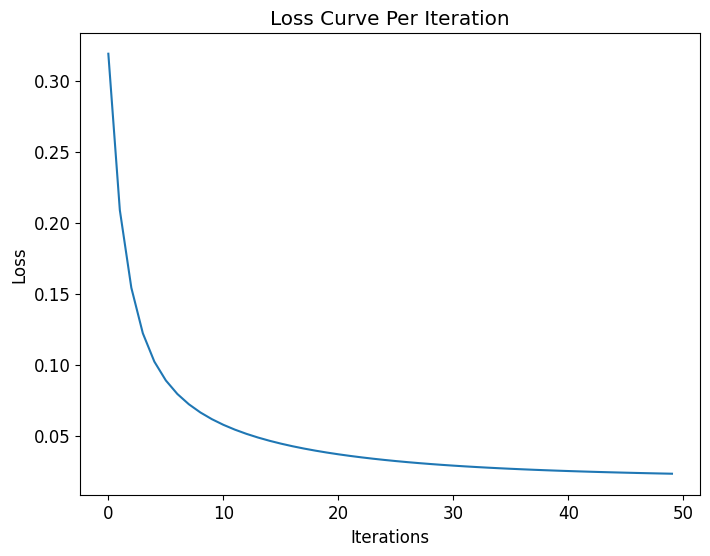

In [29]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

plt.plot(fm.history_)
plt.title('Loss Curve Per Iteration')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [9]:
# predicció del conjunt de tets i càlcul de l'"auc score"
y_pred_prob = fm.predict_proba(X_test_dtm)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC', auc)

AUC 0.9976507964918561


### Bibliografia

- [Blog: Factorization Machines](http://www.jefkine.com/recsys/2017/03/27/factorization-machines/)


## Exercici

Contesta 

1. Quan reportem la qualitat del classificador fem servir l'*AUC score*. Explica què és i proposa una implementació en Python que substituexi la funció `roc_auc_score` que hi ha al codi. 

Pots consultar qualsevol referència. Per exemple: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

*Escriu la teva resposta aquí*: 

Per entendre que és el AUC score, primer haurem de donar les següents definicions:

1. True Positive Rate (TPR) / Recall es defineix com: True Positives / (True Positives + False Negatives)
2. False Positive Rate (FPR) es el ratio de les instàncies que es classifiquen de forma incorrecta com a postives. Es defineix com: 1 - TNR, on TNR o *Specifity* es defineix com: True Negatives / (True Negatives + False Positives)
3. Reciever Operating Characteristic (ROC) es un plot de TPR entre FPR, utilitzat per classificadors binaris. La idea d'aquesta eina és principalment per veure quin *threshold* ens dona millor resultats. Això es pot saber ja que es comparan entre ells. 

<img src="img/ROC_curve.JPG" width="600">

Per últim, definim Area Under the curve (AUC) score, com diu el nom, calculem l'area que trobem en una ROC curve d'un classificador binari. Els valors que ens donará seran de entre 1.0, que serà un classificador perfecte, o 0.5, que serà un classificador purament random.

<img src="img/ROC_curve_comaprison.JPG" width="600">

Com podem veure, la regressió logística es millor model que el KNN. Per tant, la métrica que faríem servir sería el AUC score. 

In [10]:
from sklearn.metrics import roc_curve

def compute_area_under_curve_binary(y_test, y_pred_prob):
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    # Change integration method Trapez
    direction = 1
    dx = np.diff(fpr)
    if np.any(dx < 0):
        if np.all(dx <= 0):
            direction = -1

    area = direction * np.trapz(tpr, fpr)
    if isinstance(area, np.memmap):
        area = area.dtype.type(area)
    return area
    

In [11]:
binary_auc = compute_area_under_curve_binary(y_test, y_pred_prob)
print('AUC proposed', binary_auc)

AUC proposed 0.9976507964918561


# Pregunta 2

2. Hem aplicat la funció de pèrdua que fem servir, $\frac{1}{N} \sum_{i=1}^N\log \big(e^{-y_i \cdot \hat{y}(\textbf{x}_i)} + 1 \big)$, a dades etiquetades amb $y \in \{-1, 1\}$. 
+ Comprova que aquesta funció realment es minimitza quan les etiquetes i les prediccions coincideixen. Per fer-ho, pots fer una gràfica que mostri els seus valors a mesura que la semblança entre $y$ i $\hat{y} (\textbf{ x})$ va creixent. 
+ Si les dades estéssin etiquetades amb $y \in \{0, 1\}$ funcionaria? Justifica la resposta.
+ Quin és el valor mínim i màxim que pot tenir la funció de pèrdua? Normalitza el valor en funció del nombre de dades del dataset. 

*Escriu la teva resposta aquí*: 

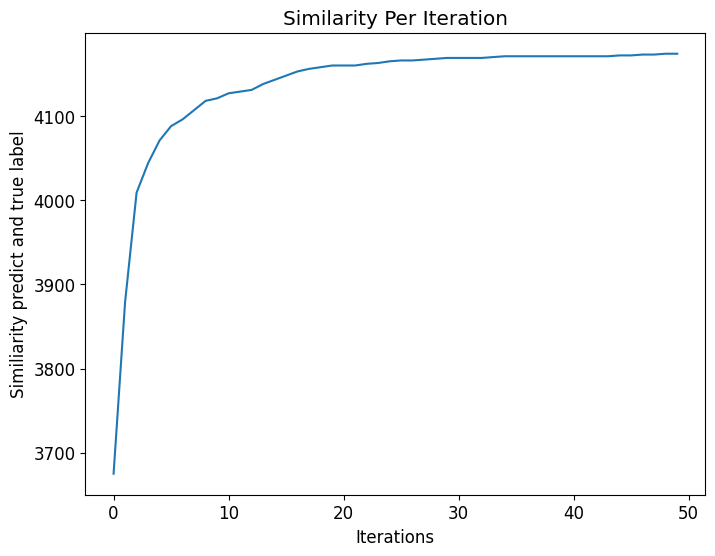

In [33]:
#Exercise 3 (modification in fit)
def similiarity_labels(fm):
    plt.rcParams['figure.figsize'] = 8, 6
    plt.rcParams['font.size'] = 12

    plt.plot(fm.similarity)
    plt.title('Similarity Per Iteration')
    plt.xlabel('Iterations')
    plt.ylabel('Similiarity predict and true label')
    plt.show()

similiarity_labels(fm)

**Exercici 4:**

En el cas de que les dades estiguessin de $\{0, 1\}$, el codi compilaría. El problema és que no optimitzariem els pessos degudament per les clases representades pel 0. Això és degut a que la nostra funció de cost és exponencial i, al fer la derivada quan tením la clase 0, obtindrem un gradient on no hi ha una direcció a optimitzar, ja que 0/2 = 0. Per aquesta raó, s'utilitzen funcions de pèrdua logarítmiques per $\{0, 1\}$ i exponencials per $\{-1, 1\}$.

**Exercici 5:**

Els valors mínim i máxim de la funció de pèrdua $\frac{1}{N} \sum_{i=1}^N\log \big(e^{-y_i \cdot \hat{y}(\textbf{x}_i)} + 1 \big)$, amb domini $(0, +\infty)$, tendeixen als valors d'aquest domini. Per lo tant, el mínim teóric sería el propi mínim del domini de la funció i el máxim, l'infinit. Per normalitzar-ho, com se'ns demana en aquest exercici, haurem d'acotar el valor que retorla la funció de predicció i que utilitzen per entranar el model. Al tractar-se d'un problema de classsificació binaría entre spam i no spam de correus, també es podría veure com un análisis del sentiment dels textos que estem processant. Per aquesta raó utilitzaré $\tanh$, ja que el domini será de $(-1, 1)$, on $-1$ indica que será spam i $1$ no spam. En cas de trobar-se en el $0$, es considedarará neutre, ja que podría tenir característiques de les dues.

In [39]:
class FactorizationMachineClassifierNormalized(BaseEstimator, ClassifierMixin):
    """
    Màquina de factorització amb descens estocàstic del gradient.
    Funciona per classificació binaria només.

    Parametres
    ----------
    n_iter : int, default 10
        Nombre d'iteracions per entrenar l'algorisme.

    n_factors : int, default 10
        Nombre/dimensió dels factors latents de les característiques.

    learning_rate : float, default 0.1
        Taxa d'aprenentatge per a l'optimitzador de descens de gradients.

    reg_coef : float, default 0.01
        Pes de regularització de pesos/coeficients.

    reg_factors : float, default 0.01
        Pes de regularització dels factors latents de les característiques.

    random_state : int, default 1234
        Llavor per als valors inicials dels factors latents

    verbose : bool, default True
        Si s'ha d'imprimir la barra de progrés durant l'entrenament.

    Atributs
    ----------
    intercept_ : double
        Terme d'intercepció, w0 en la notació que fem servir.

    coef_ : 1d ndarray, shape [n_features,]
        Coeficients, w en la notació que fem servir.

    feature_factors_ : 2d ndarray, shape [n_factors, n_features]
        Factors latents per a totes les característiques. 
        v en la notació que fem servir. 
        Si un parell de característiques tendeixen
        per coexistir sovint, llavors les seves v haurien de ser
        properes/semblants (en termes de similitud de cosinus) entre si.

    history_ : list
        Historial de la funció de pèrdua a cada iteració, útil
        per avaluar si l'algorisme va convergir o no.

    """

    def __init__(self, n_iter = 10, n_factors = 10,
                 learning_rate = 0.1, reg_coef = 0.01,
                 reg_factors = 0.01, random_state = 1234, verbose = True):
        self.n_iter = n_iter
        self.verbose = verbose
        self.reg_coef = reg_coef
        self.n_factors = n_factors
        self.reg_factors = reg_factors
        self.random_state = random_state
        self.learning_rate = learning_rate

    def fit(self, X, y):
        """
        Fit the model to the input data and label.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        y : 1d ndarray, shape [n_samples,]
            Training data's corresponding label.

        Returns
        -------
        self
        """

        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0.0

         # els factors s'inicien amb una mitjana de 0 i una desviació estàndard
         # d'1/sqrt 
        np.random.seed(self.random_state)
        self.feature_factors_ = np.random.normal(
            scale = 1 / np.sqrt(self.n_factors), size = (self.n_factors, n_features))
        
         # el gradient s'implementa d'una manera que requereix
         # la classe negativa etiquetada com a -1 en lloc de 0 
        y = y.copy().astype(np.int32)
        y[y == 0] = -1 # Nos afirma que en clase de tener clases con 0 sean -1 para la optimización

        loop = range(self.n_iter)
        if self.verbose:
            loop = trange(self.n_iter)

        self.history_ = []
        self.similarity = []
        
        for _ in loop:
            loss, self.intercept_ = _sgd_update(X.data, X.indptr, X.indices,
                               y, n_samples, n_features,
                               self.intercept_, self.coef_,
                               self.feature_factors_, self.n_factors,
                               self.learning_rate, self.reg_coef, self.reg_factors)

            self.history_.append(loss)
            
            # Exercise 2.3
            pred_y = self.predict(X)
            pred_y[pred_y == 0] = -1
            self.similarity.append(np.sum(pred_y == y))

        return self

    def predict_proba(self, X):
        """
         Estimacions de probabilitat. Les estimacions retornades per
         totes les classes estan ordenades per l'etiqueta de classes.

         Paràmetres
        ---------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Dades en format de matriu dispersa.

        Returns
        -------
        proba : 2d ndarray, shape [n_samples, n_classes]
            La probabilitat de la mostra per a cada classe del model.
        """
        pred = self._predict(X)
        pred_proba = 1.0 / (1.0 + np.exp(-pred))
        proba = np.vstack((1 - pred_proba, pred_proba)).T
        return proba

    def _predict(self, X):
        """Similar a _predict_instance però vectoritzat per a totes les mostres"""
        linear_output = X * self.coef_
        v = self.feature_factors_.T
        term = (X * v) ** 2 - (X.power(2) * (v ** 2))
        factor_output = 0.5 * np.sum(term, axis = 1)
        return self.intercept_ + linear_output + factor_output

    def predict(self, X):
        """
        Prediu les etiquetes de classe per a mostres a X.

        Parametres
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Dades en format de matriu dispersa.

        Returns
        -------
        Etiqueta de la classe predita per cada mostra.
        """
        pred_proba = self.predict_proba(X)[:, 1]
        return pred_proba.round().astype(np.int)


def _sgd_update(data, indptr, indices, y, n_samples, n_features,
                w0, w, v, n_factors, learning_rate, reg_w, reg_v):
    """
     Calcula el valor de la pèrdua de la iteració actual i actualitza
     els paràmetres amb els gradients.
    """
    loss = 0.0
    
    for i in range(n_samples):
        pred, summed = _predict_instance(data, indptr, indices, w0, w, v, n_factors, i)
        # calcula la pèrdua i el seu gradient
        loss += _log_loss(pred, y[i])
        loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)
    
        # actualització el terme de biaix
        w0 -= learning_rate * loss_gradient

        # actualització els pesos
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        for factor in range(n_factors):
            for index in range(indptr[i], indptr[i + 1]):
                feature = indices[index]
                term = summed[factor] - v[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                v[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * v[factor, feature])
    
    loss /= n_samples
    return loss, w0


def _predict_instance(data, indptr, indices, w0, w, v, n_factors, i):
    """prediu una mostra"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # w * x
    pred = w0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])
    pred = math.tanh(pred)
    # print(pred)
    return pred, summed


def _log_loss(pred, y):
    """
    funció de pèrdua
    """
    return np.log(np.exp(-pred * y) + 1.0)

In [40]:
fm_norm = FactorizationMachineClassifierNormalized(n_iter = 50, learning_rate = 0.01)
fm_norm.fit(X_train_dtm, y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:33<00:00,  1.88s/it]


FactorizationMachineClassifierNormalized(learning_rate=0.01, n_iter=50)

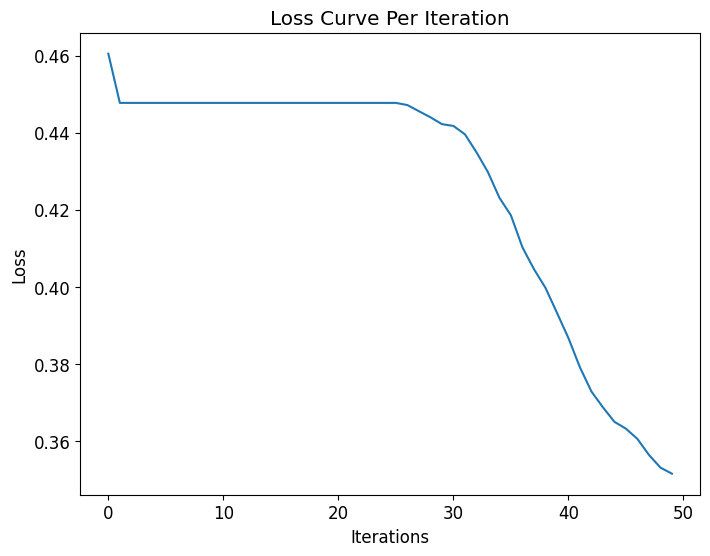

In [41]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

plt.plot(fm_norm.history_)
plt.title('Loss Curve Per Iteration')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

Normalitzant el valor que retorna la funció de predicció a $(-1, +1)$, el mínim absolut que tindrá la funció de cost será  $\ln(1/e + 1)= 0.3132$, que a cada label acertará amb el máxim grau de confiança $-1$ o $+1$ depenent de la label del missatge. El máxim será el contrari, és a dir, $\ln(e + 1) = 1.31$ on sempre dirá el contrari amb la máxima confiança en la predicció.

# Pregunta 3

3. Proposa una altra funció de pérdua (diferent a la que hi ha) que funcioni en aquest problema. Implementa-ho i calcula l'AUC score que aconsegueixes. 

*Escriu la teva resposta aquí*: 

Per aquest exercici, el primer que vaig tractar de fer és una funció de pérdua amb els labels de $\{0, 1\}$ i fer una implementació amb la *cross_entropy* vista a classe (d'aquí el nom de la classe). El problema surgeix quan el número que ens dona al fer la funció de predicció és un real i no una probabilitat de $0$ a $1$. Per tant, mirant funcions amb el Wolfram Alpha, vaig veure que simplemente $e^{-y_i \cdot \hat{y}(\textbf{x}_i)}$ té el mateix domini i, al ser una funció contínua i derivable de classe $C^{\infty}$, també ens serveix com a funció de pérdua per aquest problema. 

In [194]:
class FactorizationMachineClassifierCrossEntropy(BaseEstimator, ClassifierMixin):

    def __init__(self, n_iter = 10, n_factors = 10,
                 learning_rate = 0.1, reg_coef = 0.01,
                 reg_factors = 0.01, random_state = 1234, verbose = True):
        self.n_iter = n_iter
        self.verbose = verbose
        self.reg_coef = reg_coef
        self.n_factors = n_factors
        self.reg_factors = reg_factors
        self.random_state = random_state
        self.learning_rate = learning_rate

    def fit(self, X, y):
        """
        Fit the model to the input data and label.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        y : 1d ndarray, shape [n_samples,]
            Training data's corresponding label.

        Returns
        -------
        self
        """

        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0.0

         # els factors s'inicien amb una mitjana de 0 i una desviació estàndard
         # d'1/sqrt 
        np.random.seed(self.random_state)
        self.feature_factors_ = np.random.normal(
            scale = 1 / np.sqrt(self.n_factors), size = (self.n_factors, n_features))
        
         # el gradient s'implementa d'una manera que requereix
         # la classe negativa etiquetada com a -1 en lloc de 0 
        y = y.copy().astype(np.int32)
        y[y == -1] = -1 

        loop = range(self.n_iter)
        if self.verbose:
            loop = trange(self.n_iter)

        self.history_ = []
        self.similarity = []
        
        for _ in loop:
            loss, self.intercept_ = _sgd_update(X.data, X.indptr, X.indices,
                               y, n_samples, n_features,
                               self.intercept_, self.coef_,
                               self.feature_factors_, self.n_factors,
                               self.learning_rate, self.reg_coef, self.reg_factors)
            self.history_.append(loss)
            
        return self

    def predict_proba(self, X):
        """
         Estimacions de probabilitat. Les estimacions retornades per
         totes les classes estan ordenades per l'etiqueta de classes.

         Paràmetres
        ---------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Dades en format de matriu dispersa.

        Returns
        -------
        proba : 2d ndarray, shape [n_samples, n_classes]
            La probabilitat de la mostra per a cada classe del model.
        """
        pred = self._predict(X)
        pred_proba = 1.0 / (1.0 + np.exp(-pred))
        proba = np.vstack((1 - pred_proba, pred_proba)).T
        return proba

    def _predict(self, X):
        """Similar a _predict_instance però vectoritzat per a totes les mostres"""
        linear_output = X * self.coef_
        v = self.feature_factors_.T
        term = (X * v) ** 2 - (X.power(2) * (v ** 2))
        factor_output = 0.5 * np.sum(term, axis = 1)
        return self.intercept_ + linear_output + factor_output

    def predict(self, X):
        """
        Prediu les etiquetes de classe per a mostres a X.

        Parametres
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Dades en format de matriu dispersa.

        Returns
        -------
        Etiqueta de la classe predita per cada mostra.
        """
        pred_proba = self.predict_proba(X)[:, 1]
        return pred_proba.round().astype(np.int)


def _sgd_update(data, indptr, indices, y, n_samples, n_features,
                w0, w, v, n_factors, learning_rate, reg_w, reg_v):
    """
     Calcula el valor de la pèrdua de la iteració actual i actualitza
     els paràmetres amb els gradients.
    """
    loss = 0.0
    
    for i in range(n_samples):
        pred, summed = _predict_instance(data, indptr, indices, w0, w, v, n_factors, i)
        # calcula la pèrdua i el seu gradient
        loss += _log_loss(pred, y[i])
        #loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)
        # loss_gradient = - (np.exp(pred) * (y[i] - 1) + y[i]) / (np.exp(pred) + 1)
        # loss_gradient = y[i]*pred**(y[i]*pred)*(np.log(pred)+1)
        loss_gradient = y[i]*(-np.exp(-pred*y[i]))
        # actualització el terme de biaix
        w0 -= learning_rate * loss_gradient

        # actualització els pesos
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        for factor in range(n_factors):
            for index in range(indptr[i], indptr[i + 1]):
                feature = indices[index]
                term = summed[factor] - v[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                v[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * v[factor, feature])
    
    loss /= n_samples
    return loss, w0


def _predict_instance(data, indptr, indices, w0, w, v, n_factors, i):
    """prediu una mostra"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # w * x
    pred = w0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])
    return pred, summed


def _log_loss(pred, y):
    """
    funció de pèrdua
    """
    # return y*np.log(np.exp(-pred) + 1) + (1 - y)*np.log(np.exp(pred) + 1)
    # return np.log(np.exp(-pred * y) + 1.0)
    return np.exp(-pred*y)

In [195]:
fm2 = FactorizationMachineClassifierCrossEntropy(n_iter = 50, learning_rate = 0.1)
fm2.fit(X_train_dtm, y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.52s/it]


FactorizationMachineClassifierCrossEntropy(n_iter=50)

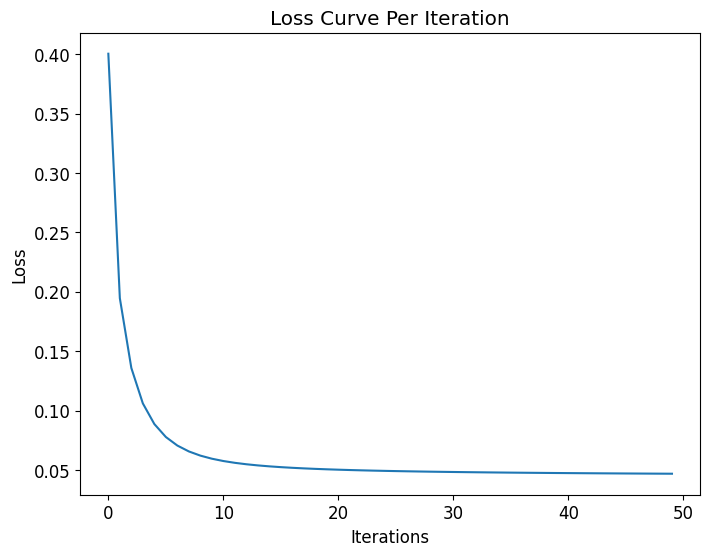

In [196]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

plt.plot(fm2.history_)
plt.title('Loss Curve Per Iteration')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [199]:
# predicció del conjunt de tets i càlcul de l'"auc score"
y_pred_prob = fm2.predict_proba(X_test_dtm)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC', auc)

AUC 0.9944424557007338


In [200]:
fm2.history_[49]

0.04677818012764777